# Fifteen minutes walking for urban city planning
To create a 15-minute city, urban planners need to address a variety of place categories to ensure that all essential services and amenities are within easy reach.

In [ ]:
from arcgis.gis import GIS
from arcgis.features import FeatureSet
from arcgis.geometry.functions import project
from geopedestrian.categories import CategoryRegistry
from geopedestrian.services import analyze_walking, solve_walking, walk_to
from georapid.client import GeoRapidClient
from georapid.factory import EnvironmentClientFactory
from ipywidgets import HBox, Layout

The `host` variable stores the URL for the geopedestrian API hosted on RapidAPI. This URL is used to connect to the GeoPedestrian services.

The `client` variable creates an instance of the `GeoRapidClient` using the `EnvironmentClientFactory`. The `create_client_with_host` method takes the host URL as an argument and returns a client instance for interacting with the geopedestrian API.

In [ ]:
host = 'geopedestrian.p.rapidapi.com'
client: GeoRapidClient = EnvironmentClientFactory.create_client_with_host(host)

This function plots the results of a 15-minute walking analysis using the specified map view. The map view must be fully initialized before calling these functions.

In [ ]:
def plot_walking_areas(map_view, client: GeoRapidClient):
    """
    Plots walking areas which are accessible by pedestrians using the specified map view.
    
    :param map_view: The map view defining the area of interest.
    :param client: The authenticated client instance for Rapid API.
    :return: Returns the walking areas as a spatially-enabled dataframe.
    """
    lat, lon = project_center(map_view)
    
    # Solve the walking areas
    walking_result = solve_walking(client, lat, lon)
    walking_areas_sdf = FeatureSet.from_geojson(walking_result).sdf
    walking_areas_sdf.spatial.plot(map_view, renderer_type='u', col='ToBreak', cmap='RdYlGn', alpha=0.35)
    map_view.zoom_to_layer(walking_areas_sdf)
    return walking_areas_sdf

def plot_walking_routes(map_view, client: GeoRapidClient, category_id: int):
    """
    Plots walking routes to places which are accessible by pedestrians using the specified map view.
    
    :param map_view: The map view defining the area of interest.
    :param client: The authenticated client instance for Rapid API.
    :param category_id: The places category of interest.
    :return: Returns the walking routes as a spatially-enabled dataframe.
    """
    lat, lon = project_center(map_view)
    
    # Solve the walking routes
    walking_result = walk_to(client, lat, lon, category_id)
    routes_geojson = walking_result['routes']
    routes_sdf = FeatureSet.from_geojson(routes_geojson).sdf
    routes_sdf.spatial.plot(map_view, renderer_type='s', palette=[0, 120, 0, 130], line_width=15)
    map_view.zoom_to_layer(routes_sdf)
    return routes_sdf

def plot_places_nearby(map_view, client: GeoRapidClient, category_id: int):
    """
    Plots places which are accessible by pedestrians using the specified map view.
    
    :param map_view: The map view defining the area of interest.
    :param client: The authenticated client instance for Rapid API.
    :param category_id: The places category of interest.
    :return: Returns the places as a spatially-enabled dataframe.
    """
    lat, lon = project_center(map_view)
    
    # Solve the walking routes
    walking_result = walk_to(client, lat, lon, category_id)
    places_geojson = walking_result['places']
    places_sdf = FeatureSet.from_geojson(places_geojson).sdf
    places_sdf.spatial.plot(map_view)
    map_view.zoom_to_layer(places_sdf)
    return places_sdf

def plot_urban_walking(map_view, client: GeoRapidClient, category_id: int):
    """
    Plots the 15 minutes walking analysis result using the specified map view.
    The map view must be fully initialized.
    
    :param map_view: The map view defining the area of interest.
    :param client: The authenticated client instance for Rapid API.
    :param category_id: The places category of interest.
    :return: Returns the analysis result as a spatially-enabled dataframe.
    """
    lat, lon = project_center(map_view)
    
    # Analyze the 15 minutes walking areas
    analysis_sdf = analyze_urban_walking(lat, lon, client, category_id)
    analysis_sdf.spatial.plot(map_view, renderer_type='u', col='hits', cmap='YlGn', alpha=0.35)
    map_view.zoom_to_layer(analysis_sdf)
    return analysis_sdf

def analyze_urban_walking(lat: float, lon: float, client: GeoRapidClient, category_id: int):
    """
    Analyzes the 15 minutes walking scenario using the specified location.
    
    :param lat: The latitude defining the point of interest.
    :param lon: The longitude defining the point of interest.
    :param client: The authenticated client instance for Rapid API.
    :param category_id: The places category of interest.
    :return: Returns the analysis result as a spatially-enabled dataframe.
    """
    analysis_result = analyze_walking(client, lat, lon, category_id)
    return FeatureSet.from_geojson(analysis_result).sdf

def project_center(map_view):
    """
    Projects the center of the map view to WGS84 coordinates.
    The map view must be fully initialized.
    
    :param map_view: The map view defining the area of interest.
    :return: Returns the center as a tuple of latitude and longitude.
    """
    # Project the map view center to WGS84
    spatial_reference = map_view.center['spatialReference']
    in_sr = spatial_reference['wkid']
    out_sr = 4326
    project_result = project([map_view.center], in_sr, out_sr)
    location = project_result[0]
    return location.y, location.x

## Define the categories of interest
This line of code creates an instance of the `CategoryRegistry` class and assigns it to the `category_registry` variable. The `CategoryRegistry` instance can be used to manage and access different categories of places for the 15-minute city analysis.

In [ ]:
category_registry = CategoryRegistry()

This line of code searches the `CategoryRegistry` instance for the category ID corresponding to the category name "Museum". The resulting ID is then assigned to the museum_id variable. This ID can be used in subsequent analysis or API calls to identify places related to museums.

In [ ]:
museum_id = category_registry.find_id('Museum')
school_id = category_registry.find_id('Primary and Secondary School')
university_id = category_registry.find_id('College and University')
restaurant_id = category_registry.find_id('Restaurant')
cafe_id = category_registry.find_id('Cafe')
bar_id = category_registry.find_id('Bar')
park_id = category_registry.find_id('Park')
sports_id = category_registry.find_id('Sports Club')
residential_id = category_registry.find_id('Residential Building')
office_id = category_registry.find_id('Office')
retail_id = category_registry.find_id('Retail')
transport_id = category_registry.find_id('Transport Hub')

## Visualize the 15 minutes walking scenarios for various cities

In [ ]:
gis = GIS()

In [ ]:
def create_map_view(gis, named_location):
    map_view = gis.map(named_location)
    map_view.basemap = 'osm'
    return map_view

def display_two_map_views(left_map_view, right_map_view):
    left_map_view.layout=Layout(flex='1 1', padding='6px', height='450px')
    right_map_view.layout=Layout(flex='1 1', padding='6px', height='450px')

    return HBox([left_map_view, right_map_view])

In [ ]:
paris_map = create_map_view(gis, 'Paris, France')
paris_map

In [ ]:
plot_walking_areas(paris_map, client)

In [ ]:
paris_map = create_map_view(gis, 'Paris, France')
paris_map

In [ ]:
plot_places_nearby(paris_map, client, museum_id)

In [ ]:
paris_map = create_map_view(gis, 'Paris, France')
paris_map

In [ ]:
plot_walking_routes(paris_map, client, museum_id)

In [ ]:
paris_map = create_map_view(gis, 'Paris, France')
paris_map

In [ ]:
paris_museum_sdf = plot_urban_walking(paris_map, client, museum_id)
paris_museum_sdf

In [ ]:
barcelona_map = create_map_view(gis, 'Barcelona, Spain')
barcelona_map

In [ ]:
barcelona_museum_sdf = plot_urban_walking(barcelona_map, client, museum_id)
barcelona_museum_sdf

In [ ]:
display_two_map_views(paris_map, barcelona_map)

## Visualize accessibility using seaborn
Analyze walking areas for various cities.
Requirements:
- seaborn

In [ ]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from tempfile import gettempdir

In [ ]:
named_categories = [{
    'name': name,
    'id': category_registry.find_id(name)
} for name in [
    'Museum', 
    'Primary and Secondary School', 
    'College and University', 
    'Restaurant', 
    'Cafe', 
    'Bar', 
    'Park', 
    'Sports Club', 
    'Residential Building', 
    'Office', 
    'Retail', 
    'Transport Hub'
    ]
]

In [ ]:
def analyze_categories(named_locations, named_categories):
    """
    Analyzes the named locations using the specified named categories.
    
    :param named_locations: Location having name, lat, and lon property.
    :param named_categories: Category having name, and id property.
    :return: Returns a pandas data frame representing the urban walking analysis results.
    """
    named_values = {
        'Location': []
    }
    for named_location in named_locations:
        location = named_location['name']
        lat = named_location['lat']
        lon = named_location['lon']
        named_values['Location'].append(location)
        for category in named_categories:
            analysis_sdf = analyze_urban_walking(lat, lon, client, category['id'])
            if category['name'] in named_values:
                values = named_values[category['name']]
                values.append(analysis_sdf['hits'].astype('int32').sum())
            else:
                named_values[category['name']] = [analysis_sdf['hits'].astype('int32').sum()]

    return pd.DataFrame(named_values)

In [ ]:
named_locations = [
    {
        'name': 'Paris, France',
        'lat': 48.86376640243179,
        'lon': 2.361657337
    }, 
    {
        'name': 'Barcelona, Spain',
        'lat': 41.38796870966504,
        'lon': 2.1699187
    }
]
    
category_df = analyze_categories(named_locations, named_categories)
category_df

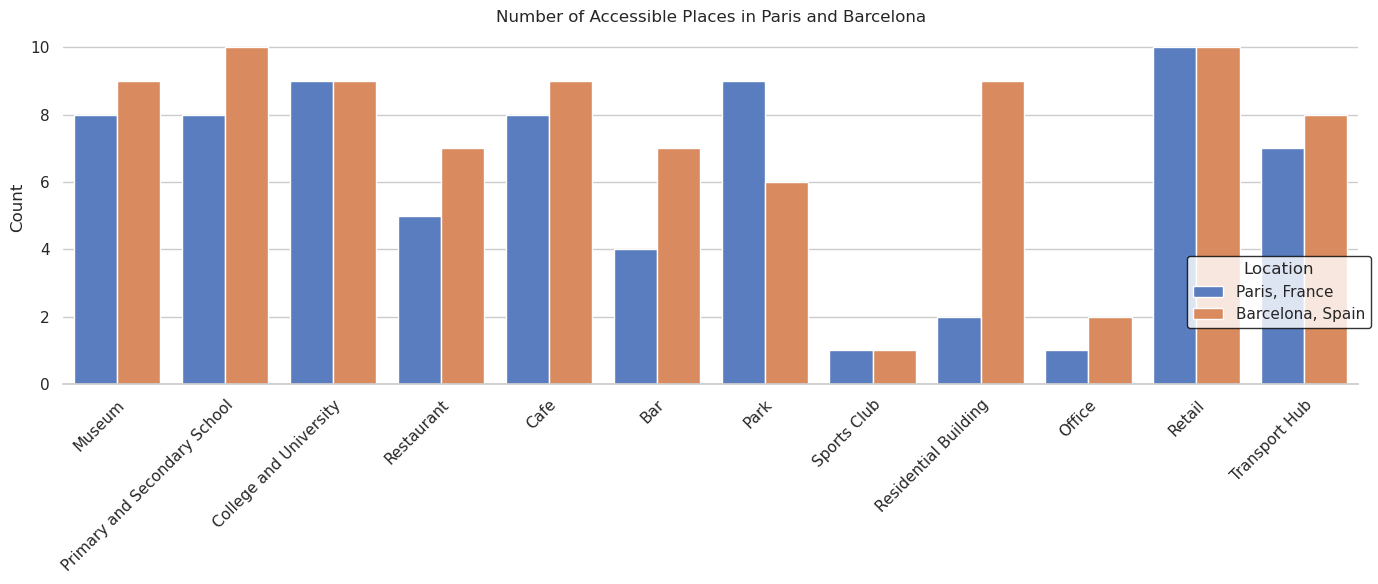

In [69]:
# Melt the dataframe for seaborn
df_melted = category_df.melt(id_vars='Location', var_name='Category', value_name='Count')

# Create the catplot with adjusted labels and legend background
sns.set(style="whitegrid")
g = sns.catplot(
    data=df_melted, kind="bar",
    x="Category", y="Count", hue="Location",
    errorbar=None, palette="muted", height=6, aspect=2
)
g.set_axis_labels("", "Count")
g.set_titles("Number of Accessible Places in Paris and Barcelona")
g.despine(left=True)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.title('Number of Accessible Places in Paris and Barcelona')
plt.tight_layout()

# Add a white background rectangle to the legend
legend = g.legend
legend.set_frame_on(True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
plt.show()

In [ ]:
def save_analysis_to_temp(df: pd.DataFrame, filename: str = 'urban_analysis.csv'):
    """
    Saves the dataframe as csv file to the temp directory.
    If the file existis it gets updated.
    
    :param df: The dataframe being saved.
    :param filename: The name of the CSV file being written.
    :return: The filepath of the CSF file.
    """
    
    # Define the path to the temporary folder
    temp_folder = gettempdir()
    file_path = os.path.join(temp_folder, filename)

    # Check if the file exists
    if os.path.exists(file_path):
        # Read the existing data
        existing_df = pd.read_csv(file_path)
        
        # Merge the dataframes, using 'Location' as the unique key
        merged_df = pd.merge(existing_df, df, on='Location', how='outer', suffixes=('', '_new'))

        # Update existing rows with new data
        for column in df.columns:
            if column != 'Location':
                merged_df[column] = merged_df[column + '_new'].combine_first(merged_df[column])
                merged_df.drop(columns=[column + '_new'], inplace=True)
    else:
        # If the file does not exist, use the provided dataframe
        merged_df = df

    # Save the merged dataframe to the temp folder
    merged_df.to_csv(file_path, index=False)
    return file_path

In [ ]:
save_analysis_to_temp(category_df)